In [1]:
import pygplates
import sys
import numpy as np
sys.path.append('../../GPlatesClassStruggle')
sys.path.append('../../atom_utils')
from raster_reconstruction_classes import *
import matplotlib.pyplot as plt
from reconstruct_atom_rasters import *
import points_spatial_tree
import points_in_polygons

%matplotlib inline
%load_ext autoreload
%autoreload 2


agegrid = GplatesRaster('../data/agegrid_6m.grd')

topography = GplatesRaster('../data/ETOPO1_0.1.grd')

anomalous_ocean = GplatesRaster('../data/Wessel_lip_seamount_mask.nc')


rotation_filename = '/Users/Simon/GIT/agegrid-dev/input_files/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'
#static_polygon_filename = '/Users/Simon/GIT/agegrid-dev/input_files/StaticPolygons/Muller_etal_AREPS_2016_StaticPolygons_MOD.gpml'
static_polygon_filename = '/Users/Simon/GIT/passive_margins/input_data/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v1.shp'



In [21]:
rotation_model = pygplates.RotationModel(rotation_filename)
static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)


In [22]:
# generate a list of lat,lon points with an equal area distribution on the sphere
equal_area_points = PointDistributionOnSphere(distribution_type='healpix',N=128)

points = [point.to_lat_lon_point() for point in equal_area_points.multipoint.get_points()]


In [23]:
# For each point, get the plate id and conjugate plate id from its containing static polygon
# Finally, sample the age grid

spatial_tree_of_uniform_recon_points = points_spatial_tree.PointsSpatialTree(points)

recon_static_polygons = []
recon_static_polygon_plate_ids = []
for static_polygon_feature in static_polygon_features:
    recon_plate_id = static_polygon_feature.get_reconstruction_plate_id()
    recon_conjugate_plate_id = static_polygon_feature.get_conjugate_plate_id()
    recon_polygon = static_polygon_feature.get_geometry()

    recon_static_polygon_plate_ids.append((recon_plate_id,recon_conjugate_plate_id))
    recon_static_polygons.append(recon_polygon)
        
point_plate_pairs = points_in_polygons.find_polygons_using_points_spatial_tree(
    points, spatial_tree_of_uniform_recon_points, recon_static_polygons, recon_static_polygon_plate_ids)

point_ages = point_age = agegrid.sample_using_gmt(equal_area_points.longitude,equal_area_points.latitude)



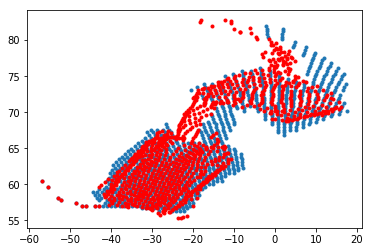

In [24]:
def return_conjugate_points(target_plate_pair):

    points_and_conjugate_points = []
    for point, point_age, plate_ids in zip(points, point_ages, point_plate_pairs):

        if plate_ids is None:
            continue
        elif plate_ids[0] not in target_plate_pair:
            continue
        elif plate_ids[1] not in target_plate_pair:
            continue
        else:
            
            if not np.isnan(point_age):

                finite_rotation = rotation_model.get_rotation(float(point_age), int(plate_ids[0]), 0, int(plate_ids[1]))

                reconstructed_point = finite_rotation * pygplates.PointOnSphere(point)

                points_and_conjugate_points.append([point.to_lat_lon()[1],
                                                    point.to_lat_lon()[0],
                                                    reconstructed_point.to_lat_lon()[1],
                                                    reconstructed_point.to_lat_lon()[0],
                                                    plate_ids[0]])
            
    return points_and_conjugate_points

points_and_conjugate_points = return_conjugate_points([301,102])

plt.plot(zip(*points_and_conjugate_points)[0],zip(*points_and_conjugate_points)[1],'.')
plt.plot(zip(*points_and_conjugate_points)[2],zip(*points_and_conjugate_points)[3],'r.')
plt.show()


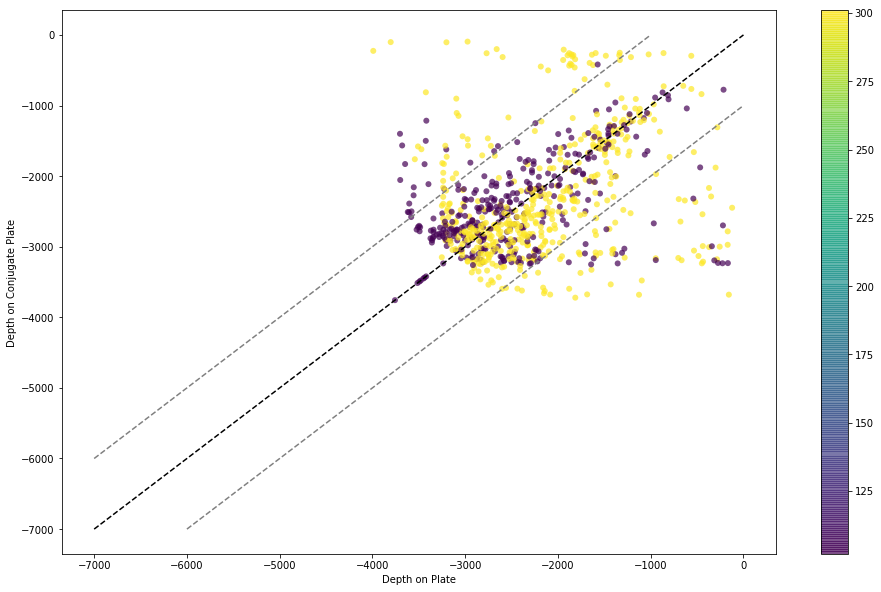

In [25]:
point_depth = topography.sample_using_gmt(zip(*points_and_conjugate_points)[0],zip(*points_and_conjugate_points)[1])    
conj_point_depth = topography.sample_using_gmt(zip(*points_and_conjugate_points)[2],zip(*points_and_conjugate_points)[3])

point_depth_mask = anomalous_ocean.sample_using_gmt(zip(*points_and_conjugate_points)[0],zip(*points_and_conjugate_points)[1])    
conj_point_depth_mask = anomalous_ocean.sample_using_gmt(zip(*points_and_conjugate_points)[2],zip(*points_and_conjugate_points)[3])
mask = np.any(np.vstack((point_depth_mask,conj_point_depth_mask)),axis=0)

#print point_depth[mask]
#print zip(*points_and_conjugate_points)[4][mask]

plt.figure(figsize=(16,10))
#plt.plot(point_depth,conj_point_depth,'r.',alpha=0.7)
#plt.plot(point_depth_701,conj_point_depth_701,'b.',alpha=0.7)
plt.scatter(point_depth[~mask],conj_point_depth[~mask],c=np.array(zip(*points_and_conjugate_points)[4])[~mask],edgecolors='',alpha=0.7)
plt.plot([-7000,0],[-7000,0],'k--')
plt.plot([-7000,-1000],[-6000,0],'--',color='gray')
plt.plot([-6000,0],[-7000,-1000],'--',color='gray')
plt.xlabel('Depth on Plate')
plt.ylabel('Depth on Conjugate Plate')
#plt.legend(['South America','Africa'])
plt.colorbar()


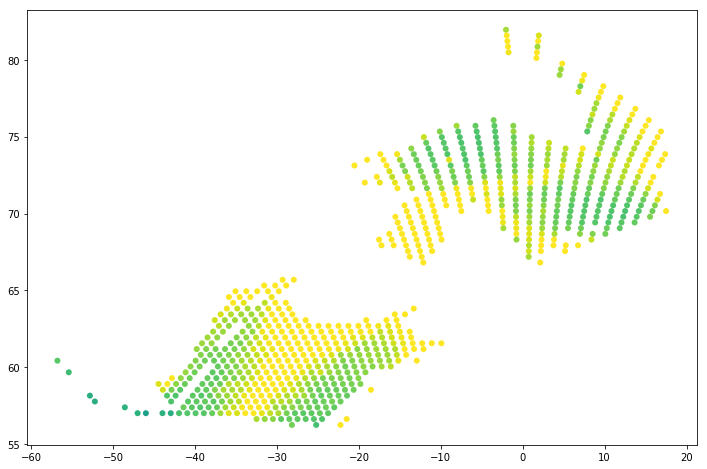

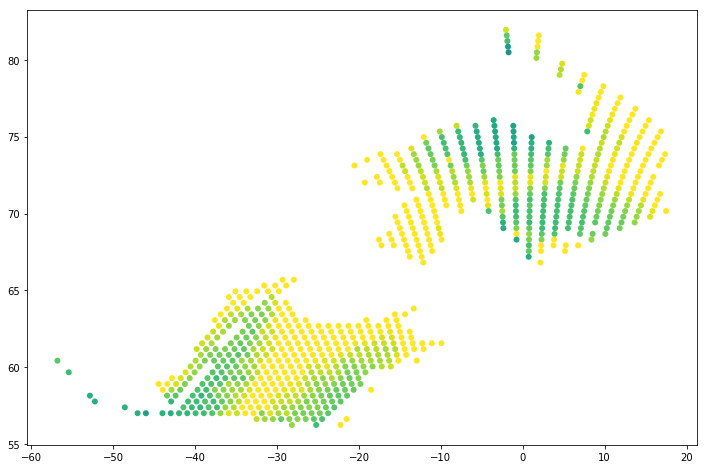

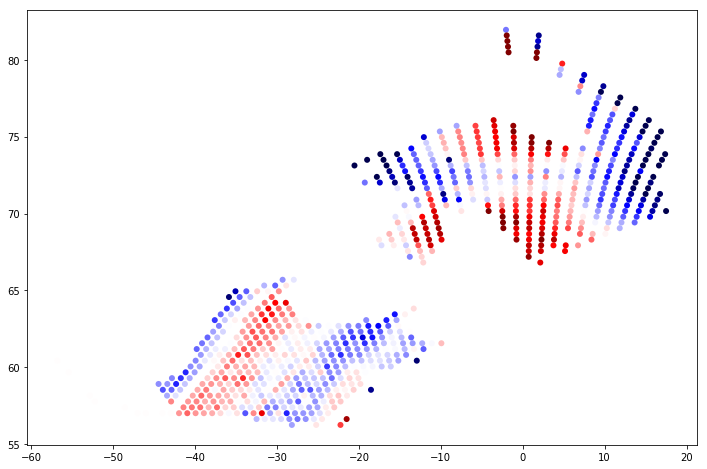

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=np.mean(np.vstack((point_depth,conj_point_depth)),axis=0)[~mask],
            edgecolors='',vmin=-6000,vmax=-2000)
#plt.colorbar()

plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=point_depth[~mask],
            edgecolors='',vmin=-6000,vmax=-2000)

plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=np.mean(np.vstack((point_depth,conj_point_depth)),axis=0)[~mask] - point_depth[~mask],
            edgecolors='',vmin=-1000,vmax=1000,
            cmap=plt.cm.seismic)